In [1]:
##Setting up the libraries
import os
import pandas as pd
import numpy as np
import torch
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
DIR = '/home/sandip/Desktop/AV_Hackathon/DL_comp/'
#path_to_train = DIR + '/train/images/'
train_labels = pd.read_csv(DIR + "/train/train.csv")

# Setting up the transformations upfront###

In [4]:
magnitude = 0.005
xtra_tfms = [jitter(magnitude=magnitude, p=0.5)]
tfms = get_transforms(do_flip=True, max_lighting=0.2, max_zoom=1.1, max_warp=0.2,xtra_tfms=xtra_tfms)

In [5]:
np.random.seed(42)
src = (ImageList.from_csv(DIR, 'train.csv', folder='train-jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [6]:
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats))

# let's review some random images post transformations along with Labels

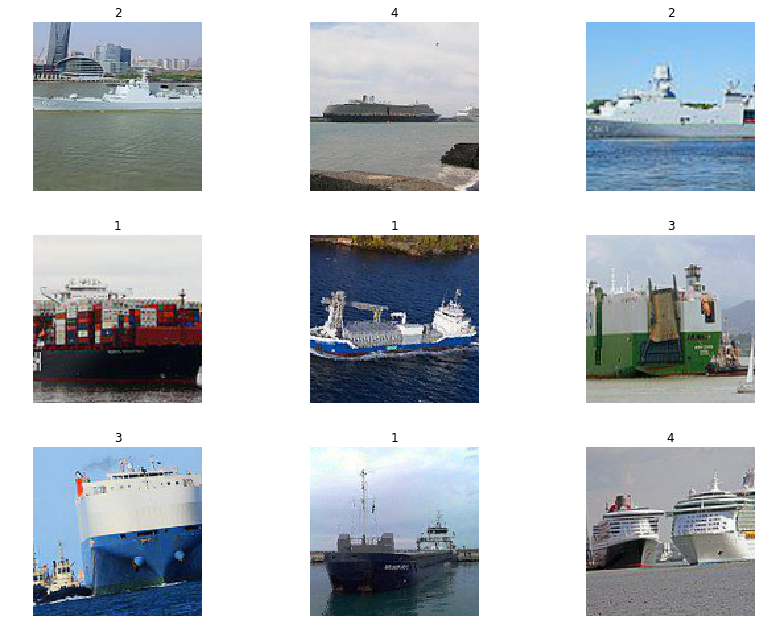

In [7]:
data.show_batch(rows=3, figsize=(12, 9))

# Download and set up the pre-trained model

In this case we use resnet152. In my experiments I found other versions of resnet giving inferior results.

In [8]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet152, metrics=[acc_02, f_score])

In [9]:
##Review the structure of the CNN
learn

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
1,1,2,3,2
Path: /home/sandip/Desktop/AV_Hackathon/DL_comp;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
4,1,1,3,4
Path: /home/sandip/Desktop/AV_Hackathon/DL_comp;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02


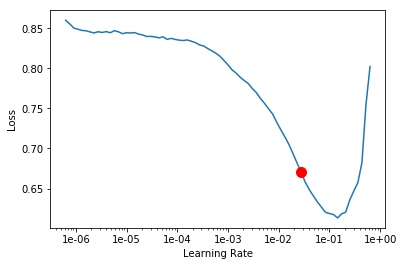

In [11]:
learn.recorder.plot(suggestion=True)

In [12]:
lr = 2.75E-02
learn.fit_one_cycle(16, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.321180,0.156128,0.924000,0.882590,00:27
1,0.187411,0.526193,0.833600,0.645638,00:26
2,0.193274,0.435914,0.860960,0.712743,00:26
3,0.201185,0.537081,0.825760,0.608038,00:27
4,0.197228,0.285611,0.894720,0.807924,00:27
5,0.188485,0.147905,0.929440,0.890800,00:27
6,0.176029,0.582823,0.843040,0.684381,00:27
7,0.156315,0.651942,0.889280,0.774667,00:26
8,0.157890,0.157558,0.931360,0.879429,00:26
9,0.138637,0.141676,0.937760,0.895181,00:27


In [13]:
learn.save('av_dl_resnet152_stage1')

In [14]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


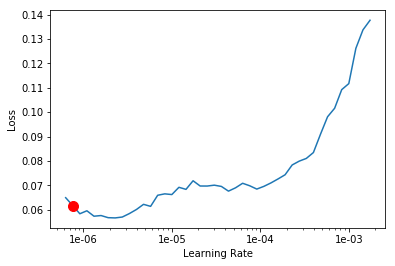

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(16, slice(1e-05, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.068697,0.095183,0.952000,0.922210,00:34
1,0.079030,0.183476,0.928320,0.863352,00:34
2,0.107056,0.151440,0.935680,0.888495,00:34
3,0.106545,0.142939,0.941760,0.891257,00:34
4,0.106494,0.124196,0.941120,0.898781,00:34
5,0.106936,0.147908,0.935520,0.893905,00:34
6,0.102329,0.115905,0.947200,0.911714,00:34
7,0.091266,0.133667,0.938240,0.900457,00:34
8,0.085381,0.115042,0.942720,0.917300,00:34
9,0.081951,0.096897,0.953920,0.927695,00:34


In [17]:
learn.save('av_dl_resnet152_stage2')

# Switch Resolution

In [18]:
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data

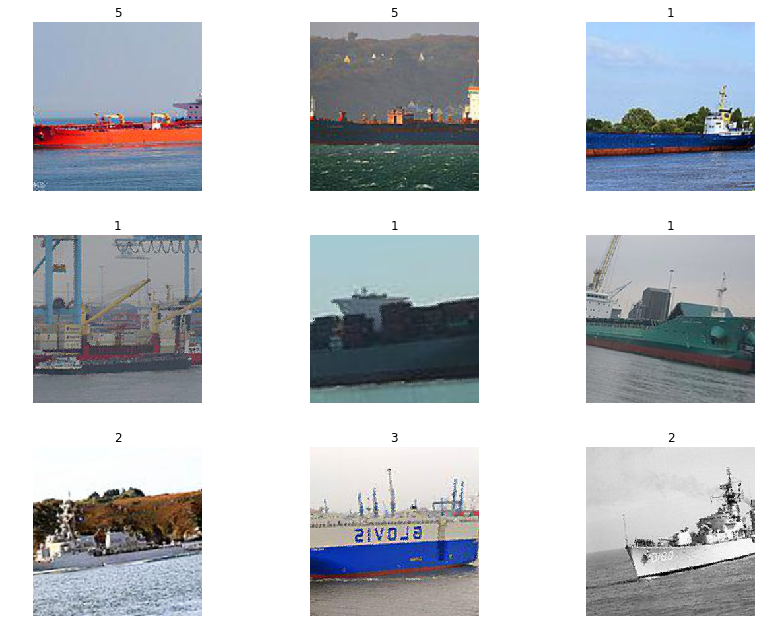

In [19]:
data.show_batch(rows=3, figsize=(12, 9))

In [20]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


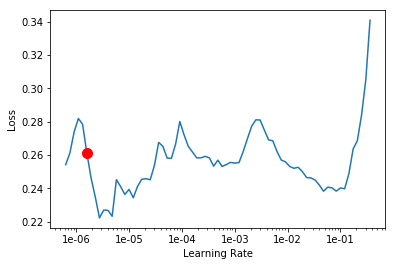

In [21]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [22]:
lr=0.0005
learn.fit_one_cycle(32, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.240997,0.201645,0.929920,0.864133,01:44
1,0.269760,0.194728,0.929920,0.859238,01:43
2,0.239576,0.180610,0.933600,0.867276,01:43
3,0.226757,0.159966,0.932320,0.879181,01:43
4,0.199906,0.148333,0.933600,0.884114,01:43
5,0.173284,0.137533,0.932000,0.892305,01:43
6,0.187198,0.131511,0.933760,0.897581,01:43
7,0.168820,0.127498,0.934080,0.904781,01:43
8,0.144112,0.116707,0.935200,0.912572,01:43
9,0.156920,0.111537,0.938240,0.915257,01:43


In [23]:
learn.save('av_dl_resnet152_stage3')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(32, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.116767,0.089268,0.957760,0.934076,02:14
1,0.101974,0.086951,0.954240,0.931010,02:15
2,0.098488,0.083961,0.957440,0.939429,02:15
3,0.086566,0.081646,0.957600,0.941276,02:15
4,0.094574,0.078013,0.958400,0.940991,02:15
5,0.100732,0.075622,0.964320,0.945524,02:15
6,0.085206,0.078331,0.961280,0.943314,02:16
7,0.094722,0.071623,0.964800,0.948629,02:15
8,0.069903,0.076301,0.963520,0.944990,02:16
9,0.069459,0.072191,0.964000,0.946724,02:16


In [25]:
learn.save('av_dl_resnet152_stage4')

In [26]:
learn.export()

# Make Predictions

In [27]:
path_test = '/home/sandip/Desktop/AV_Hackathon/DL_comp/test-jpg'

In [28]:
## No TTA predictions first
dataframes = []
for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    learn = load_learner(DIR, test=test)
    preds, y= learn.get_preds(ds_type=DatasetType.Test)
    y = torch.argmax(preds, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)


In [29]:
sub_df = pd.DataFrame(df)
sub_df.head()

,image,category
0,2901960,3
1,2843667,1
2,1874363,4
3,2807078,2
4,2060547,2


In [30]:
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_ResNet152_256X256_noTTA_06042019.csv', index=False)

In [32]:
preds_notta = preds

In [33]:
preds_notta

tensor([[6.2931e-05, 9.7796e-06, 9.9904e-01, 5.3269e-04, 2.9938e-05],
        [9.9773e-01, 3.7201e-05, 3.5675e-06, 6.1025e-06, 1.0539e-03],
        [5.5673e-05, 1.3191e-05, 1.0768e-05, 9.9946e-01, 1.3767e-04],
        ...,
        [9.7482e-05, 2.2594e-05, 2.0307e-04, 9.9940e-01, 3.7605e-05],
        [9.9820e-01, 1.6154e-04, 2.4435e-05, 4.2180e-05, 2.7008e-04],
        [2.6934e-02, 4.0929e-05, 3.2281e-05, 1.0457e-06, 9.6502e-01]])

In [38]:
torch.save(preds_notta, DIR + 'resent152_256X256_preds_notta.pt')

In [39]:
test_tensor_load = torch.load(DIR + 'resent152_256X256_preds_notta.pt')

In [40]:
test_tensor_loadfit_one_cycle

tensor([[6.2931e-05, 9.7796e-06, 9.9904e-01, 5.3269e-04, 2.9938e-05],
        [9.9773e-01, 3.7201e-05, 3.5675e-06, 6.1025e-06, 1.0539e-03],
        [5.5673e-05, 1.3191e-05, 1.0768e-05, 9.9946e-01, 1.3767e-04],
        ...,
        [9.7482e-05, 2.2594e-05, 2.0307e-04, 9.9940e-01, 3.7605e-05],
        [9.9820e-01, 1.6154e-04, 2.4435e-05, 4.2180e-05, 2.7008e-04],
        [2.6934e-02, 4.0929e-05, 3.2281e-05, 1.0457e-06, 9.6502e-01]])

In [41]:
dataframes = []
for directory in ('test-jpg'):
    test = ImageList.from_folder(path_test)
    learn = load_learner(DIR, test=test)
    preds, y= learn.TTA(ds_type=DatasetType.Test)
    y = torch.argmax(preds, dim=1)+1
    #thresh = 0.45
    #labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image':fnames, 'category':y}, columns=['image', 'category'])
    dataframes.append(df)


In [42]:
sub_df = pd.DataFrame(df)
sub_df.head()

,image,category
0,2901960,3
1,2843667,1
2,1874363,4
3,2807078,2
4,2060547,2


In [43]:
sub_df.columns = ['image1', 'category']
sub_df['image']=sub_df['image1']+".jpg"
sub_df.drop(['image1'],axis=1,inplace=True)
sub_df = sub_df.reindex(columns= ['image','category'])
sub_df.to_csv(DIR +'/submission_Fastai_ResNet152_256X256_TTA_06042019.csv', index=False)

In [44]:
torch.save(preds, DIR + 'resent152_256X256_preds_tta.pt')

In [45]:
preds

tensor([[5.2586e-04, 1.5641e-05, 9.9866e-01, 1.0779e-03, 2.0267e-04],
        [9.9754e-01, 4.4900e-05, 7.2741e-06, 1.5083e-05, 9.8052e-04],
        [2.8151e-04, 1.4560e-03, 2.2161e-05, 9.9823e-01, 7.6729e-05],
        ...,
        [2.4540e-02, 8.2583e-03, 2.2035e-02, 8.9147e-01, 7.9362e-04],
        [9.9350e-01, 4.7470e-03, 6.2709e-05, 2.4987e-04, 3.9293e-04],
        [2.3727e-01, 1.5883e-02, 2.5137e-04, 2.4471e-05, 7.3473e-01]])